# AI‑Powered Resume Screening — Bias & Performance Analysis
*(Refactored structure generated 2025-09-14)*

This notebook provides a clean, modular workflow to analyze potential bias in AI‑assisted resume screening.
It assumes a CSV similar to Kaggle’s **AI‑Powered Resume Screening Dataset (2025)** with columns like:

- `AI Score (0-100)`, `Recruiter Decision`, `Hire_binary`
- `gender`, `Experience (Years)`, `Job Role`, `Skills`
- engineered fields like `num_skills`, `Skills_list`, etc.

> Replace the `DATA_PATH` below with your local path.


## 0. Imports & Config

In [1]:
# === Imports ===
import os, re, json, math, textwrap, random, itertools, warnings
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns

# Plotting
import matplotlib.pyplot as plt

# Modeling
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, roc_auc_score, average_precision_score,
    precision_recall_fscore_support, brier_score_loss, confusion_matrix
)
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance

warnings.filterwarnings('ignore')

# === Config ===
RANDOM_STATE = 42
TEST_SIZE = 0.25
N_SPLITS = 5

# Columns expected (adjust as needed)
TARGET_COL = "Hire_binary"               # 0/1
AI_SCORE_COL = "AI Score (0-100)"        # numerical 0..100
DECISION_COL = "Recruiter Decision"      # optional text label

GROUP_COLS = ["gender"]                  # sensitive attributes to audit
NUM_COLS   = ["Experience (Years)", "Projects Count", "Salary Expectation ($)", AI_SCORE_COL, "num_skills"]
CAT_COLS   = ["Job Role"]

# For robust plots
plt.rcParams['figure.figsize'] = (10, 4)
plt.rcParams['figure.dpi'] = 110


## 1. Load Data

In [2]:
# Point this to your CSV (e.g., 'applicants_with_demographics.csv')
DATA_PATH = Path(r"C:\Users\Mohadeseh Yousofy\OneDrive - NORDAKADEMIE\Nordakademie\ki\notebooks\applicants_with_demographics.csv")

assert DATA_PATH.exists(), f"CSV not found: {DATA_PATH.resolve()}"
df = pd.read_csv(DATA_PATH)
print(df.shape)
df.head(3)

(1000, 15)


,Resume_ID,Name,Skills,Experience (Years),Education,Certifications,Job Role,Recruiter Decision,Salary Expectation ($),Projects Count,AI Score (0-100),Skills_list,Hire_binary,gender,ethnicity
0,1,Ashley Ali,"TensorFlow, NLP, Pytorch",10,B.Sc,NaN,AI Researcher,Hire,104895,8,100,"['tensorflow', 'nlp', 'pytorch']",1,female,unknown
1,2,Wesley Roman,"Deep Learning, Machine Learning, Python, SQL",10,MBA,Google ML,Data Scientist,Hire,113002,1,100,"['deep learning', 'machine learning', 'python'...",1,male,unknown
2,3,Corey Sanchez,"Ethical Hacking, Cybersecurity, Linux",1,MBA,Deep Learning Specialization,Cybersecurity Analyst,Hire,71766,7,70,"['ethical hacking', 'cybersecurity', 'linux']",1,unknown,Hispanic


## 2. Schema & Quality Checks

In [3]:
## 2. Schema & Qualität prüfen (robuster)

# Pflichtspalten
MANDATORY_COLS = {TARGET_COL} | set(GROUP_COLS) | set(CAT_COLS)
missing_mand = [c for c in MANDATORY_COLS if c not in df.columns]
if missing_mand:
    raise ValueError(f"Fehlende Pflichtspalten: {missing_mand}")

# Optionale Spalten & Features
if 'num_skills' not in df.columns:
    if 'Skills' in df.columns:
        df['num_skills'] = df['Skills'].fillna('').apply(
            lambda s: len([x for x in re.split(r'[;,|]\s*', str(s)) if x.strip()])
        )
    else:
        # Du könntest entscheiden, ob du num_skills weglässt oder mit Default 0
        df['num_skills'] = 0
        print("Warnung: 'Skills' fehlt → num_skills auf 0 gesetzt")

# Jetzt prüfen, dass alle Numerischen und Kategorischen Spalten existieren
NUM_COLS_ACTUAL = [c for c in NUM_COLS if c in df.columns]
CAT_COLS_ACTUAL = [c for c in CAT_COLS if c in df.columns]

print("Verfügbare numerische Spalten:", NUM_COLS_ACTUAL)
print("Verfügbare kategorische Spalten:", CAT_COLS_ACTUAL)

# Null-Raten prüfen für Pflicht + verwendete optionale Spalten
cols_to_check = list(MANDATORY_COLS) + NUM_COLS_ACTUAL + CAT_COLS_ACTUAL
print("\nNullraten (%):")
print((df[cols_to_check].isna().mean() * 100).round(2))

# Zielvariable
if df[TARGET_COL].isna().any():
    print(f"Achtung: {df[TARGET_COL].isna().sum()} Zeilen haben kein Target → diese werden entfernt")
    df = df.dropna(subset=[TARGET_COL]).copy()


Verfügbare numerische Spalten: ['Experience (Years)', 'Projects Count', 'Salary Expectation ($)', 'AI Score (0-100)', 'num_skills']
Verfügbare kategorische Spalten: ['Job Role']

Nullraten (%):
gender                    0.0
Job Role                  0.0
Hire_binary               0.0
Experience (Years)        0.0
Projects Count            0.0
Salary Expectation ($)    0.0
AI Score (0-100)          0.0
num_skills                0.0
Job Role                  0.0
dtype: float64


## 3. Quick EDA

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Experience (Years),1000.0,NaN,NaN,NaN,4.896,3.112695,0.0,2.0,5.0,8.0,10.0
Projects Count,1000.0,NaN,NaN,NaN,5.133,3.23137,0.0,2.0,5.0,8.0,10.0
Salary Expectation ($),1000.0,NaN,NaN,NaN,79994.486,23048.472549,40085.0,60415.75,79834.5,99583.25,119901.0
AI Score (0-100),1000.0,NaN,NaN,NaN,83.95,20.983036,15.0,70.0,100.0,100.0,100.0
num_skills,1000.0,NaN,NaN,NaN,3.017,0.805829,2.0,2.0,3.0,4.0,4.0
gender,1000,3,male,486,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Job Role,1000,4,AI Researcher,257,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Hire_binary,1000.0,NaN,NaN,NaN,0.812,0.390908,0.0,1.0,1.0,1.0,1.0



gender counts:
gender
male       486
female     474
unknown     40
Name: count, dtype: int64


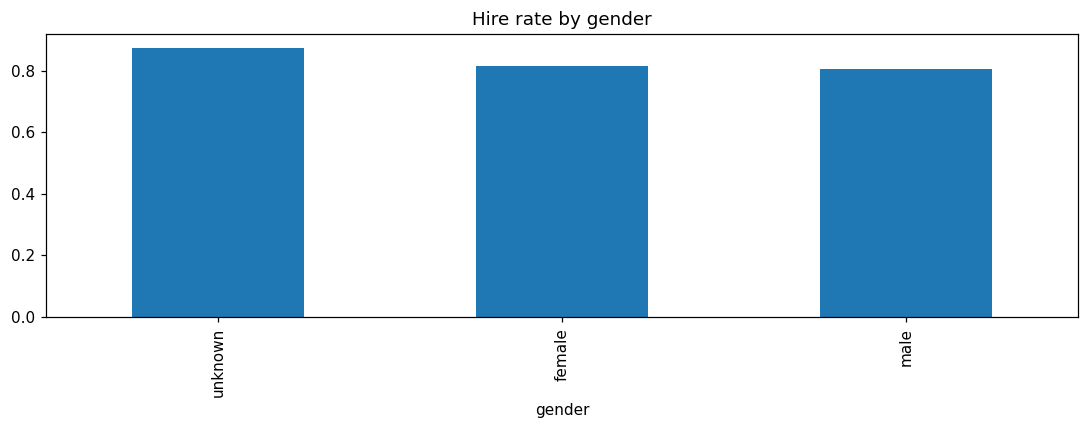

In [4]:
# Numeric overview
display(df[NUM_COLS + GROUP_COLS + CAT_COLS + [TARGET_COL]].describe(include='all').T)

# Group counts
for g in GROUP_COLS:
    print(f"\n{g} counts:") 
    print(df[g].value_counts(dropna=False))

# Outcome by group
for g in GROUP_COLS:
    rate = df.groupby(g)[TARGET_COL].mean().sort_values(ascending=False)
    ax = rate.plot.bar(title=f"Hire rate by {g}")
    plt.tight_layout(); plt.show()

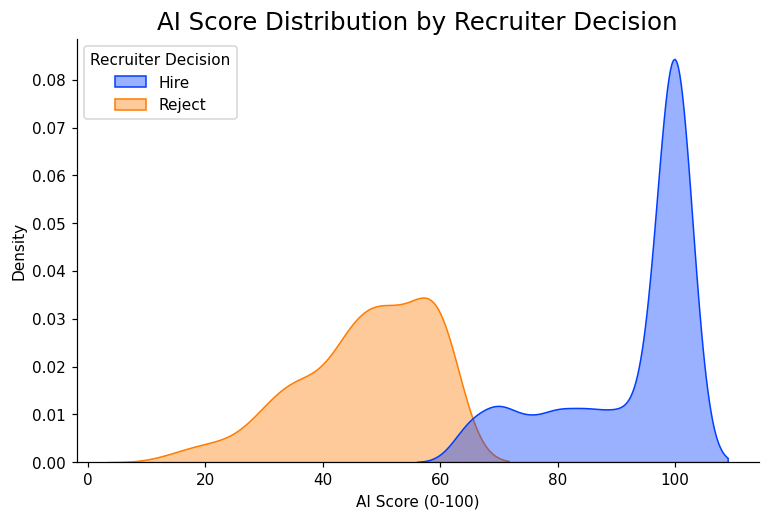

In [5]:
plt.figure(figsize=(8,5))
sns.kdeplot(data=df, x='AI Score (0-100)', hue='Recruiter Decision', fill=True, common_norm=False, palette='bright', alpha=0.4)
plt.title('AI Score Distribution by Recruiter Decision', fontsize=16)
plt.xlabel('AI Score (0-100)')
plt.ylabel('Density')
sns.despine()
plt.show()

### Univariate Data Analysis

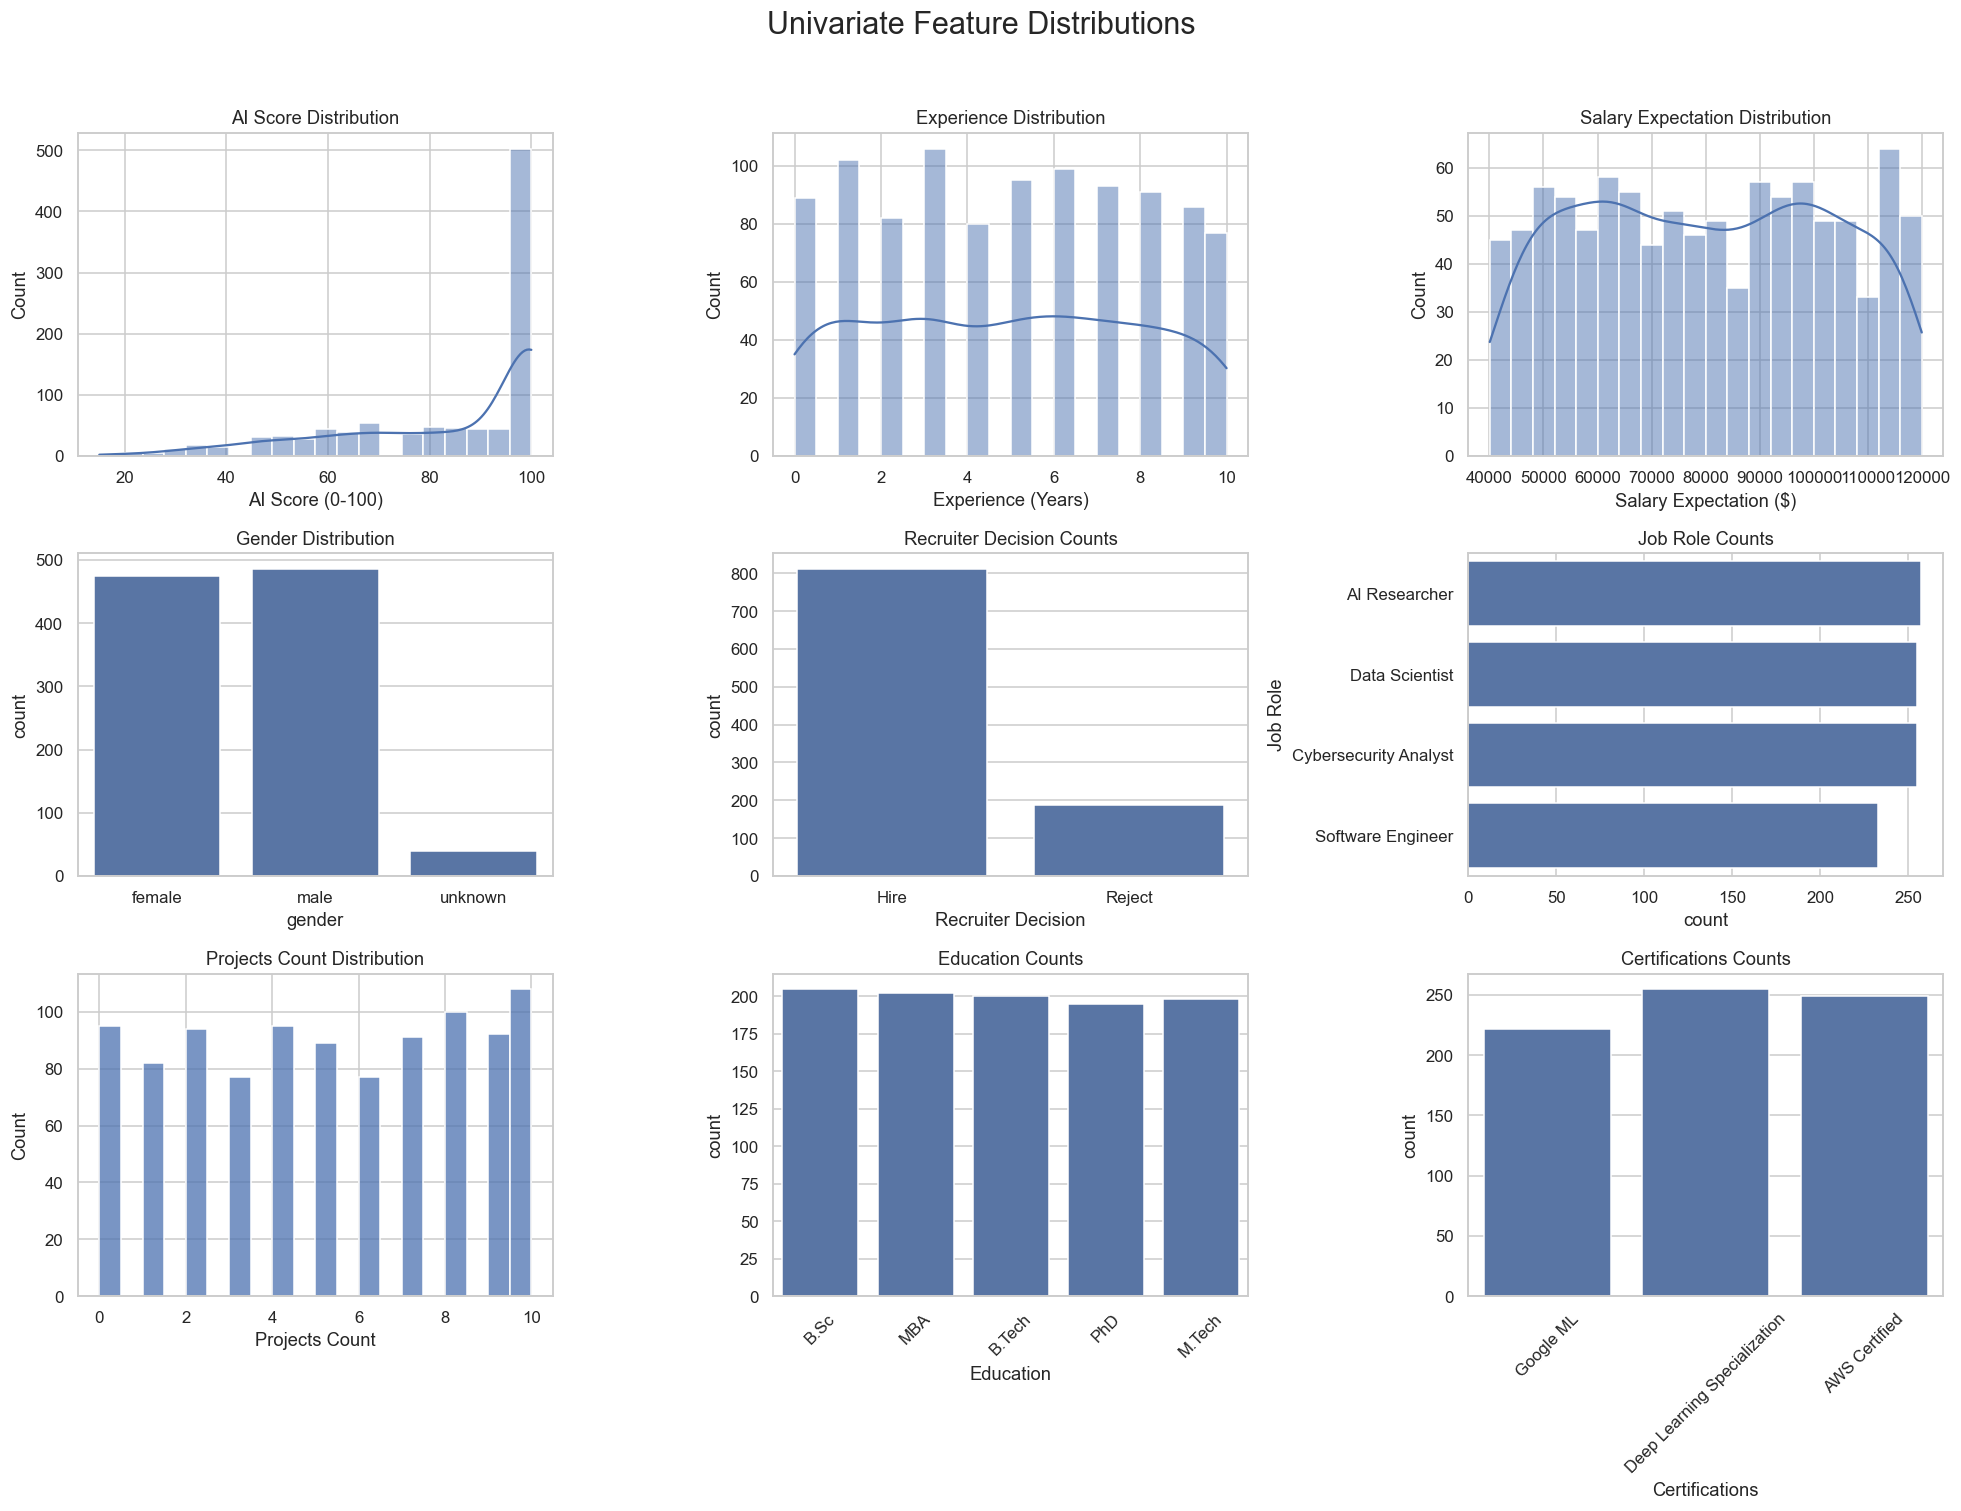

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Make plots look nicer
sns.set(style="whitegrid")

# ------------------------
# 1) Univariate analysis
# ------------------------
fig, axes = plt.subplots(3, 3, figsize=(18, 14))
fig.suptitle("Univariate Feature Distributions", fontsize=20)

# Numeric distributions
sns.histplot(df["AI Score (0-100)"], bins=20, kde=True, ax=axes[0,0])
axes[0,0].set_title("AI Score Distribution")

sns.histplot(df["Experience (Years)"], bins=20, kde=True, ax=axes[0,1])
axes[0,1].set_title("Experience Distribution")

sns.histplot(df["Salary Expectation ($)"], bins=20, kde=True, ax=axes[0,2])
axes[0,2].set_title("Salary Expectation Distribution")

# Categorical counts
sns.countplot(x="gender", data=df, ax=axes[1,0])
axes[1,0].set_title("Gender Distribution")

sns.countplot(x="Recruiter Decision", data=df, ax=axes[1,1])
axes[1,1].set_title("Recruiter Decision Counts")

sns.countplot(y="Job Role", data=df, order=df["Job Role"].value_counts().index, ax=axes[1,2])
axes[1,2].set_title("Job Role Counts")

# More numeric features
sns.histplot(df["Projects Count"], bins=20, kde=False, ax=axes[2,0])
axes[2,0].set_title("Projects Count Distribution")

sns.countplot(x="Education", data=df, ax=axes[2,1])
axes[2,1].set_title("Education Counts")
axes[2,1].tick_params(axis="x", rotation=45)

sns.countplot(x="Certifications", data=df, ax=axes[2,2])
axes[2,2].set_title("Certifications Counts")
axes[2,2].tick_params(axis="x", rotation=45)

plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

### Multivariate Data Analysis

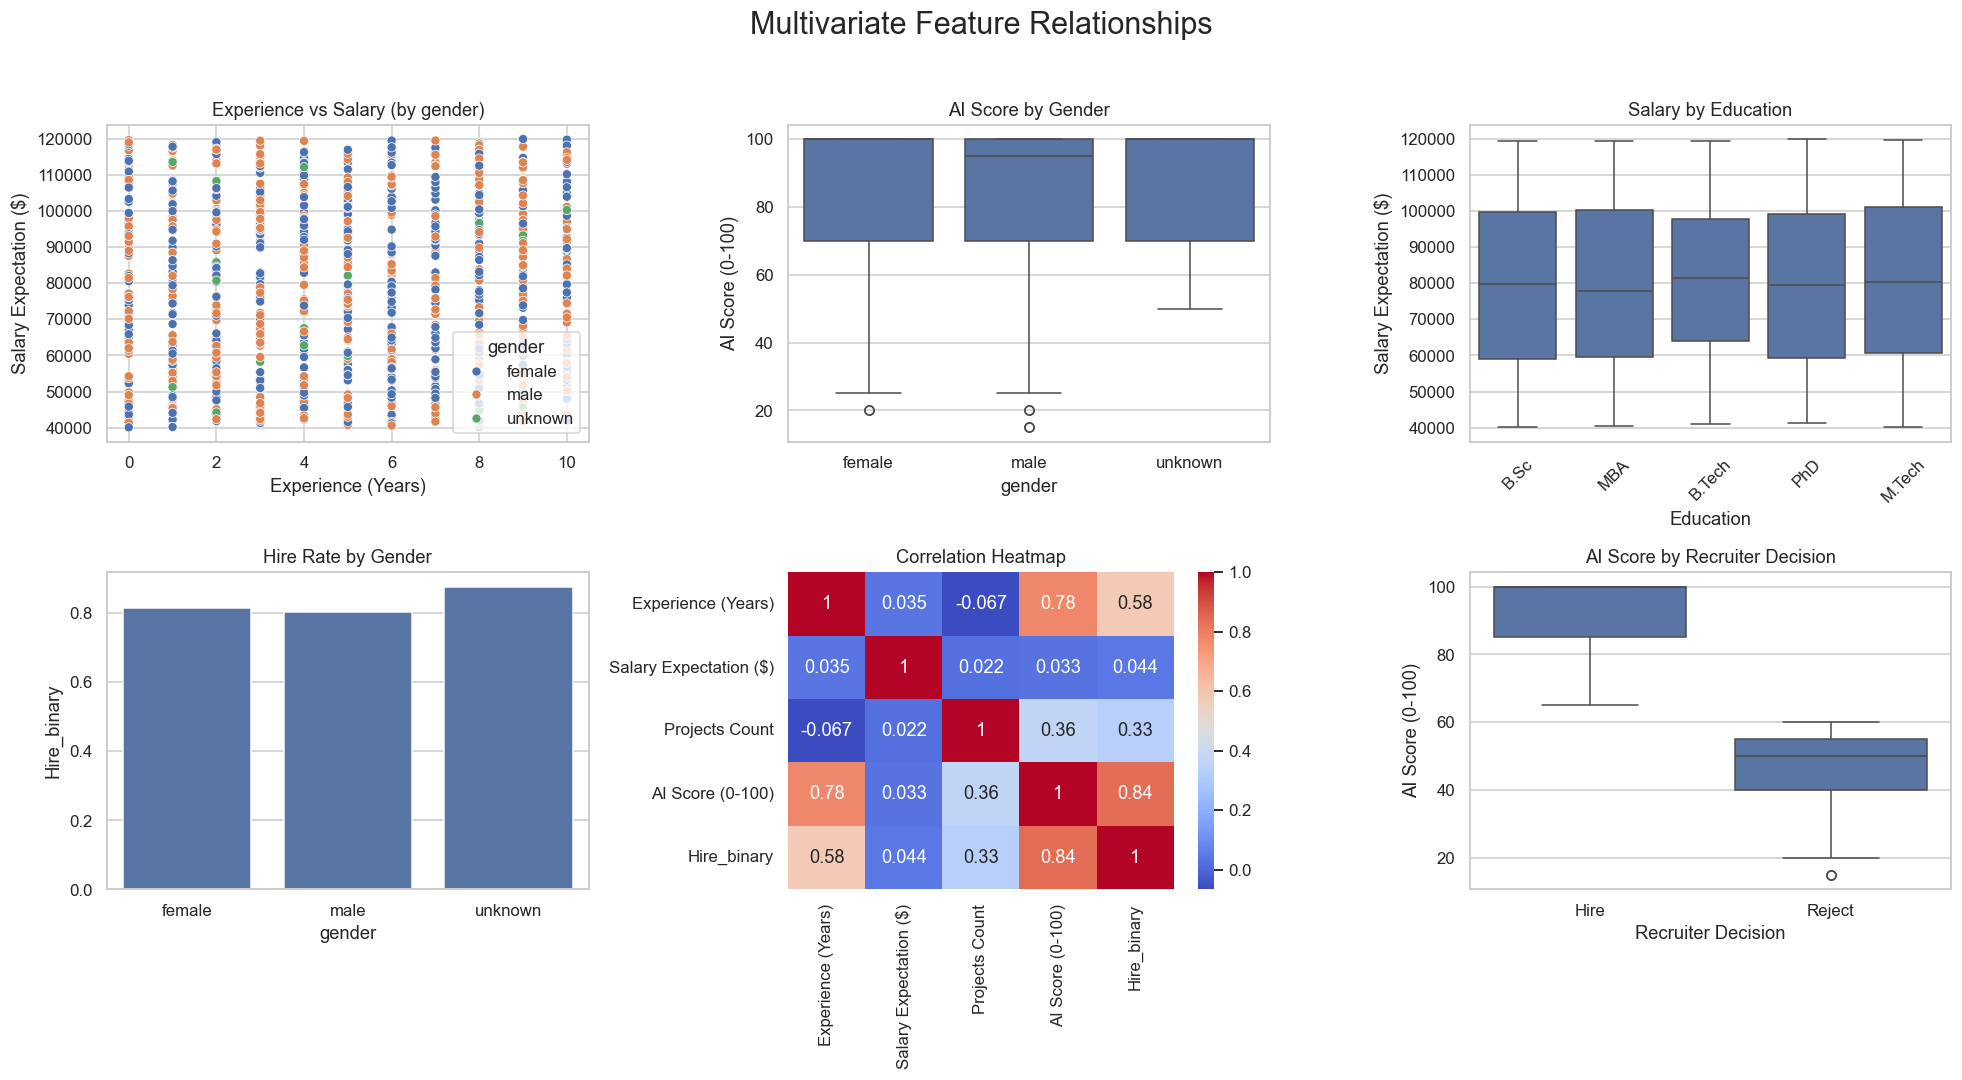

In [7]:
# ------------------------
# 2) Multivariate analysis
# ------------------------
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle("Multivariate Feature Relationships", fontsize=20)

# Scatter: Experience vs Salary
sns.scatterplot(x="Experience (Years)", y="Salary Expectation ($)", hue="gender", data=df, ax=axes[0,0])
axes[0,0].set_title("Experience vs Salary (by gender)")

# Box: AI Score by Gender
sns.boxplot(x="gender", y="AI Score (0-100)", data=df, ax=axes[0,1])
axes[0,1].set_title("AI Score by Gender")

# Box: Salary by Education
sns.boxplot(x="Education", y="Salary Expectation ($)", data=df, ax=axes[0,2])
axes[0,2].set_title("Salary by Education")
axes[0,2].tick_params(axis="x", rotation=45)

# Bar: Hire rate by Gender
hire_rate = df.groupby("gender")["Hire_binary"].mean().reset_index()
sns.barplot(x="gender", y="Hire_binary", data=hire_rate, ax=axes[1,0])
axes[1,0].set_title("Hire Rate by Gender")

# Correlation heatmap
corr = df[["Experience (Years)", "Salary Expectation ($)", "Projects Count", "AI Score (0-100)", "Hire_binary"]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", ax=axes[1,1])
axes[1,1].set_title("Correlation Heatmap")

# Box: AI Score by Recruiter Decision
sns.boxplot(x="Recruiter Decision", y="AI Score (0-100)", data=df, ax=axes[1,2])
axes[1,2].set_title("AI Score by Recruiter Decision")

plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

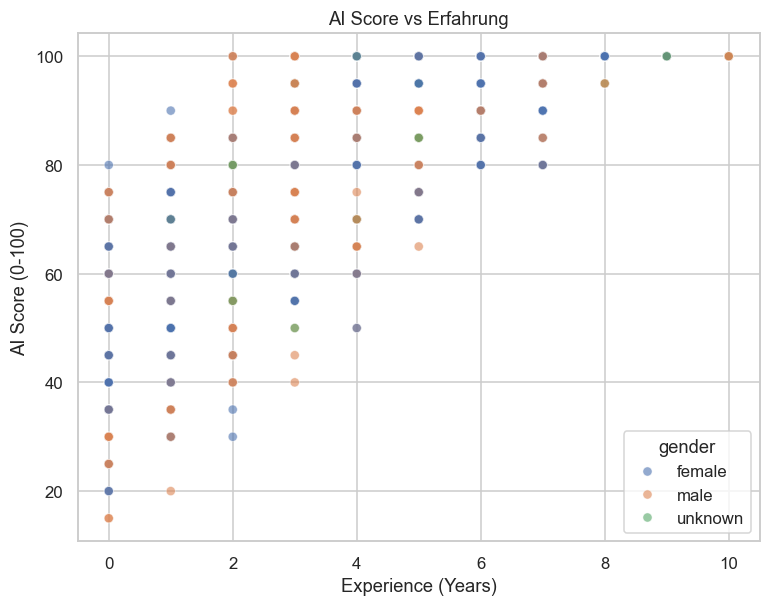

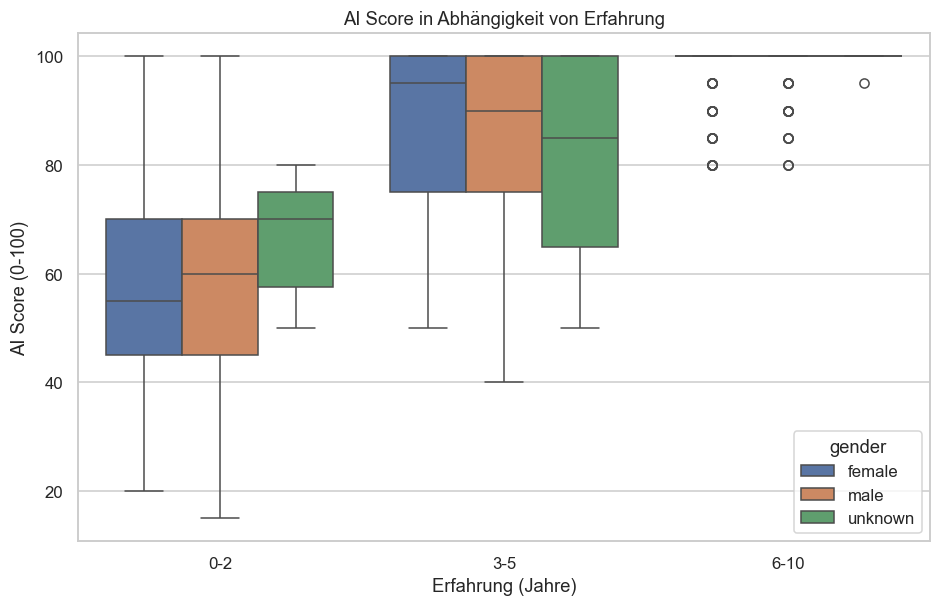

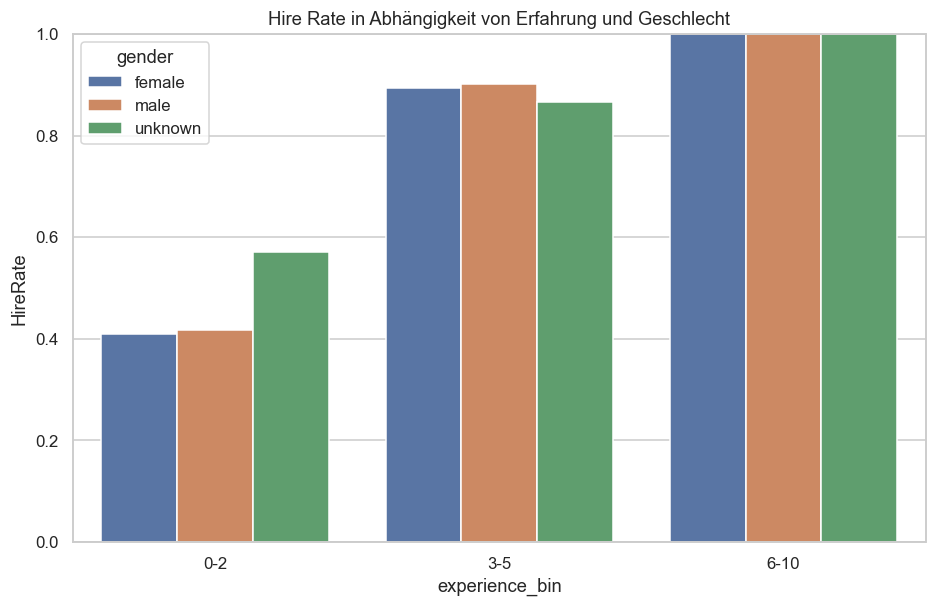


Summary by experience group & gender:
  experience_bin   gender  mean_ai_score  hire_rate  count
0            0-2   female          56.85       0.41    127
1            0-2     male          58.13       0.42    139
2            0-2  unknown          66.43       0.57      7
3            3-5   female          87.03       0.89    123
4            3-5     male          85.59       0.90    143
5            3-5  unknown          82.00       0.87     15
6           6-10   female          98.37       1.00    224
7           6-10     male          98.92       1.00    204
8           6-10  unknown          99.72       1.00     18


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set(style="whitegrid")

# 1) Scatterplot: Experience vs AI Score, farbig nach Gender
plt.figure(figsize=(8,6))
sns.scatterplot(
    x="Experience (Years)", 
    y="AI Score (0-100)", 
    hue="gender", 
    data=df, 
    alpha=0.6
)
plt.title("AI Score vs Erfahrung")
plt.show()

# 2) Boxplot: AI Score nach Erfahrungsklassen und Gender
# Klassen bauen (0-2, 3-5, 6-10 Jahre)
bins = [0,2,5,10]
labels = ["0-2","3-5","6-10"]
df["experience_bin"] = pd.cut(df["Experience (Years)"], bins=bins, labels=labels, include_lowest=True)

plt.figure(figsize=(10,6))
sns.boxplot(
    x="experience_bin", 
    y="AI Score (0-100)", 
    hue="gender", 
    data=df
)
plt.title("AI Score in Abhängigkeit von Erfahrung")
plt.xlabel("Erfahrung (Jahre)")
plt.show()

# 3) Hire rate nach Experience und Gender
hire_rate = (
    df.groupby(["experience_bin","gender"])["Hire_binary"]
      .mean()
      .reset_index()
)

plt.figure(figsize=(10,6))
sns.barplot(
    x="experience_bin", y="Hire_binary", hue="gender", data=hire_rate
)
plt.title("Hire Rate in Abhängigkeit von Erfahrung und Geschlecht")
plt.ylabel("HireRate")
plt.ylim(0,1)
plt.show()

# 4) Zusammenfassung als Tabelle
summary = (
    df.groupby(["experience_bin","gender"])
      .agg(mean_ai_score=("AI Score (0-100)","mean"),
           hire_rate=("Hire_binary","mean"),
           count=("Hire_binary","size"))
      .reset_index()
)

print("\nSummary by experience group & gender:")
print(summary.round(2))


In [9]:
import pandas as pd

# === Konfiguration ===
MIN_EXP = 0
MAX_EXP = 5

EXP = 1    # Beispiel: gleiche Erfahrungsgruppe 0–5 Jahre
# ======================

# 1) Filter auf Erfahrung in gewünschter Range
subset = df[
#    (df["Experience (Years)"] >= MIN_EXP) &
#    (df["Experience (Years)"] <= MAX_EXP) &
    (df["Experience (Years)"] == EXP) &
    (df["gender"].isin(["female","male"])) &  # nur klare gender
    (df["Job Role"] == "Cybersecurity Analyst") &  # nur Data Scientists
    (df["num_skills"] == 4)   # nur 4 skills
].copy()

# 2) Übersicht nach gender
summary = (
    subset.groupby("gender")
          .agg(mean_ai_score=("AI Score (0-100)", "mean"),
               mean_num_skills=("num_skills", "mean"),
               hire_rate=("Hire_binary", "mean"),
               count=("Hire_binary", "size"))
          .reset_index()
)

print("Vergleich Männer vs Frauen bei gleicher Erfahrung:")
print(summary.round(2))

# 3) Optional: Crosstab für Hire vs Gender (innerhalb dieser Erfahrungsrange)
ct = pd.crosstab(subset["gender"], subset["Recruiter Decision"], normalize="index")
print("\nProportion Hire vs Reject innerhalb der Range:")
print(ct.round(2))

# 4) End-Tabelle anzeigen
result = subset[[
    "Name","gender","Experience (Years)","num_skills","Skills_list",
    "AI Score (0-100)","Recruiter Decision","Education","Job Role"
]].reset_index(drop=True)

result.head(20)   # Tabelle der ersten 20 Kandidaten


# Dieser Codeblock macht folgendes:
# - filtert den Datensatz nach Kandidaten mit einer Erfahrung EXP = 1
# - filtert den Datensatz nach Kandidaten mit einer Erfahrung zwischen MIN_EXP und MAX_EXP --- IGNORE ---
# - zeigt eine Übersicht der gefilterten Kandidaten nach Geschlecht mit durchschnittlichem AI Score, durchschnittlicher Anzahl Skills, Einstellungsrate und Gesamtanzahl
# - zeigt eine Kreuztabelle der Einstellungsproportionen nach Geschlecht innerhalb dieser

# Ergebnisse:
# Vergleich Männer vs Frauen bei gleicher Erfahrung:
# Vergleich Männer vs Frauen bei gleicher Erfahrung:
#   gender  mean_ai_score  mean_num_skills  hire_rate  count
#  0  female           58.9             3.02       0.40     50
#  1    male           60.2             3.02       0.51     49

# Proportion Hire vs Reject innerhalb der Range:
# Recruiter Decision  Hire  Reject
# gender                          
# female              0.40    0.60
# male                0.51    0.49

# Das zeigt, dass Männer in dieser Erfahrungsgruppe (1 Jahr) eine höhere Einstellungsrate (51%) haben als Frauen (40%), obwohl sie eine ähnliche durchschnittliche Anzahl an Skills (3.02) und einen leicht höheren durchschnittlichen AI Score (60.2 vs 58.9) aufweisen.
# Die Gesamtanzahl der Kandidaten in dieser Gruppe ist mit 50 Frauen und 49 Männern vergleichbar. Erfahrungsgruppe
# - zeigt eine Tabelle mit Name, Geschlecht, Erfahrung, Anzahl Skills, Skills Liste, AI Score, Entscheidung, Bildung und Job Rolle der Kandidaten an


Vergleich Männer vs Frauen bei gleicher Erfahrung:
   gender  mean_ai_score  mean_num_skills  hire_rate  count
0  female          61.25              4.0        0.5      4
1    male          78.33              4.0        1.0      3

Proportion Hire vs Reject innerhalb der Range:
Recruiter Decision  Hire  Reject
gender                          
female               0.5     0.5
male                 1.0     0.0


,Name,gender,Experience (Years),num_skills,Skills_list,AI Score (0-100),Recruiter Decision,Education,Job Role
0,April Flores,female,1,4,"['networking', 'cybersecurity', 'ethical hacki...",55,Reject,B.Sc,Cybersecurity Analyst
1,Derrick Mendoza,male,1,4,"['cybersecurity', 'ethical hacking', 'networki...",70,Hire,M.Tech,Cybersecurity Analyst
2,John James,male,1,4,"['linux', 'networking', 'cybersecurity', 'ethi...",80,Hire,B.Sc,Cybersecurity Analyst
3,Nancy Brown,female,1,4,"['ethical hacking', 'linux', 'cybersecurity', ...",80,Hire,B.Tech,Cybersecurity Analyst
4,Thomas Hutchinson,male,1,4,"['ethical hacking', 'networking', 'linux', 'cy...",85,Hire,B.Sc,Cybersecurity Analyst
5,Theresa Hansen,female,1,4,"['cybersecurity', 'networking', 'linux', 'ethi...",70,Hire,B.Sc,Cybersecurity Analyst
6,Tina Booth,female,1,4,"['cybersecurity', 'ethical hacking', 'linux', ...",40,Reject,MBA,Cybersecurity Analyst


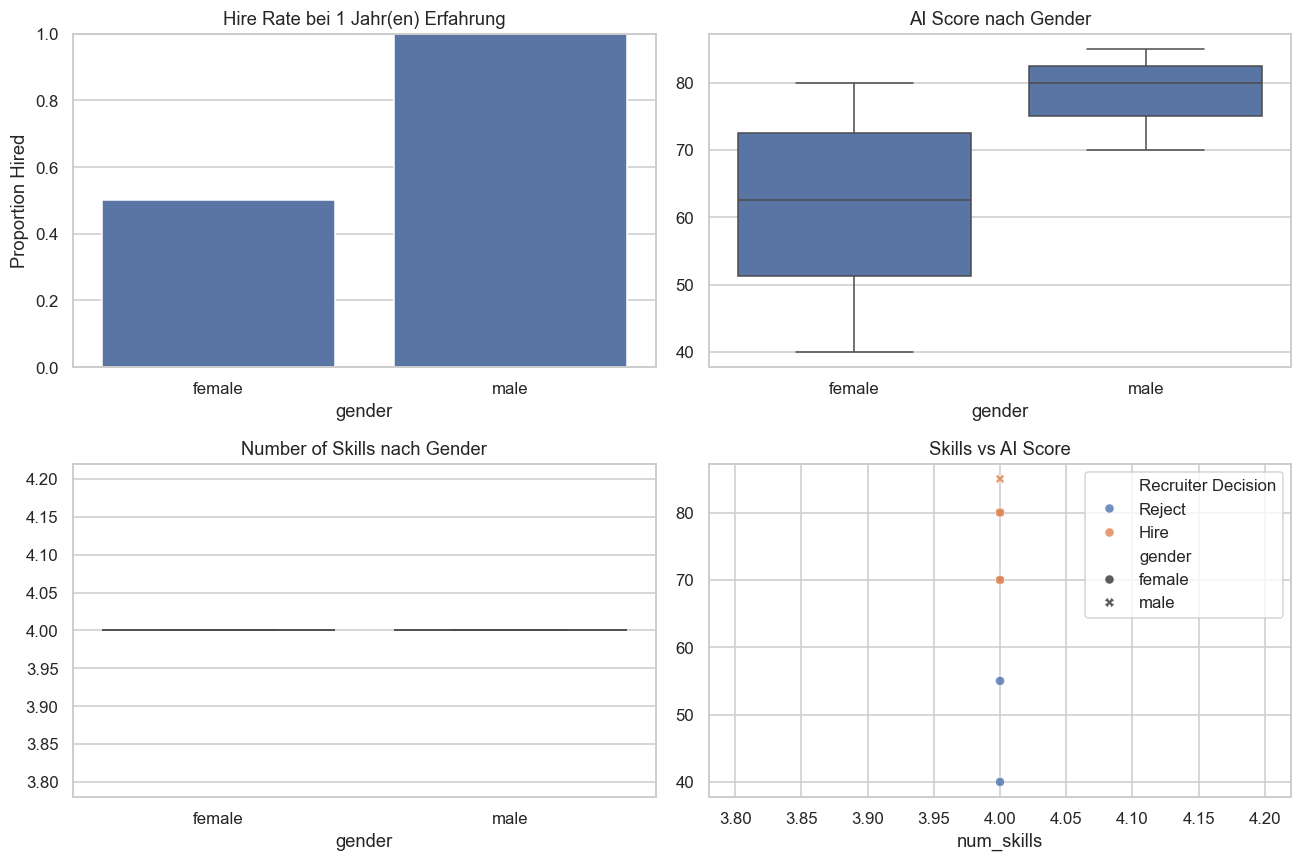

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

fig, axes = plt.subplots(2, 2, figsize=(12,8))  # 2x2 Grid

# 1) Hire Rate Barplot
sns.barplot(
    x="gender", y="Hire_binary",
    data=subset, ci=None, ax=axes[0,0]
)
axes[0,0].set_title(f"Hire Rate bei {EXP} Jahr(en) Erfahrung")
axes[0,0].set_ylim(0,1)
axes[0,0].set_ylabel("Proportion Hired")

# 2) AI Score Boxplot
sns.boxplot(
    x="gender", y="AI Score (0-100)", data=subset, ax=axes[0,1]
)
axes[0,1].set_title("AI Score nach Gender")
axes[0,1].set_ylabel("")

# 3) Number of Skills Boxplot
sns.boxplot(
    x="gender", y="num_skills", data=subset, ax=axes[1,0]
)
axes[1,0].set_title("Number of Skills nach Gender")
axes[1,0].set_ylabel("")

# 4) Scatter: Skills vs AI Score
sns.scatterplot(
    x="num_skills", y="AI Score (0-100)",
    hue="Recruiter Decision", style="gender",
    data=subset, alpha=0.8, ax=axes[1,1]
)
axes[1,1].set_title("Skills vs AI Score")
axes[1,1].set_ylabel("")

plt.tight_layout()
plt.show()


## 4. Train / Test Split

In [11]:
X = df[NUM_COLS + CAT_COLS].copy()
y = df[TARGET_COL].astype(int)

# Split stratified on y
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
)

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, NUM_COLS),
        ('cat', categorical_transformer, CAT_COLS)
    ]
)

clf = Pipeline(steps=[
    ('prep', preprocess),
    ('model', LogisticRegression(max_iter=200, class_weight='balanced', random_state=RANDOM_STATE))
])

clf.fit(X_train, y_train)

proba_test = clf.predict_proba(X_test)[:,1]
pred_test = (proba_test >= 0.5).astype(int)

def print_scores(y_true, proba, pred):
    acc = accuracy_score(y_true, pred)
    auc = roc_auc_score(y_true, proba)
    ap  = average_precision_score(y_true, proba)
    brier = brier_score_loss(y_true, proba)
    p, r, f1, _ = precision_recall_fscore_support(y_true, pred, average='binary', zero_division=0)
    print(f"Accuracy={acc:.3f}  AUC={auc:.3f}  AP={ap:.3f}  F1={f1:.3f}  Precision={p:.3f}  Recall={r:.3f}  Brier={brier:.3f}")

print_scores(y_test, proba_test, pred_test)

Accuracy=0.972  AUC=1.000  AP=1.000  F1=0.982  Precision=1.000  Recall=0.966  Brier=0.016


## 5. Group-wise Metrics & Fairness Indicators

,gender,count,selection_rate,TPR,FPR,AUC,pos_rate_true
0,female,123,0.813008,0.990099,0.0,1.0,0.821138
1,male,119,0.756303,0.947368,0.0,1.0,0.798319
2,unknown,8,0.750000,0.857143,0.0,1.0,0.875000


metric,AUC,FPR,TPR,pos_rate_true,selection_rate
group,,,,,
gender,0.0,0.0,0.132956,0.076681,0.063008


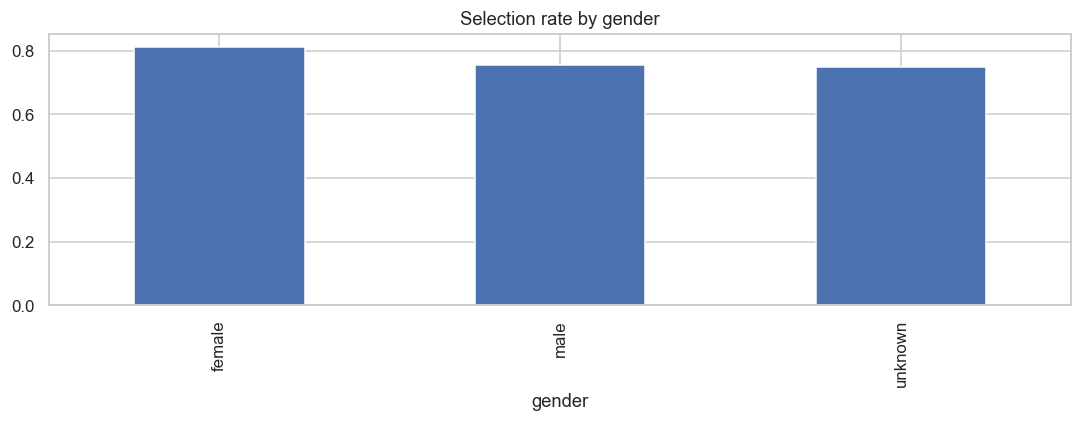

In [12]:
# === 5. Group-wise Metrics & Fairness Indicators (robust) ===
def group_rates(df_eval, group_col, y_true, y_score, y_pred, threshold=0.5):
    out = []
    # groupby inklusive NaNs als eigene Gruppe (pandas>=1.1: dropna=False)
    for gval, idx in df_eval.groupby(group_col, dropna=False).groups.items():
        yt = y_true.loc[idx]
        ys = y_score.loc[idx]
        yp = y_pred.loc[idx]

        # Guards für leere/konstante Gruppen
        if len(idx) == 0 or yt.nunique() == 0:
            auc = float("nan")
        else:
            try:
                auc = roc_auc_score(yt, ys)
            except ValueError:
                auc = float("nan")

        tpos = ((yp == 1) & (yt == 1)).sum()
        fpos = ((yp == 1) & (yt == 0)).sum()
        ppos = max((yt == 1).sum(), 1)
        nneg = max((yt == 0).sum(), 1)

        out.append({
            group_col: gval if pd.notna(gval) else "NaN/Unknown",
            "count": len(idx),
            "selection_rate": float((yp == 1).mean()),
            "TPR": float(tpos / ppos),        # Equal Opportunity
            "FPR": float(fpos / nneg),
            "AUC": float(auc),
            "pos_rate_true": float(yt.mean()),
        })
    return pd.DataFrame(out)

# --- Eval-Frame aufbauen: gleiche Indizes wie X_test / y_test ---
eval_df = X_test.copy()
# Gruppen-Spalten aus dem Original df anhand der Test-Indizes nachziehen
for g in GROUP_COLS:
    if g in df.columns:
        eval_df[g] = df.loc[X_test.index, g]
    else:
        print(f"Warnung: GROUP_COL '{g}' fehlt im df → wird übersprungen")

# Vorhersagen anhängen (Index bleibt erhalten)
eval_df["proba"] = proba_test
eval_df["pred"]  = pred_test

# Nur existierende Gruppen verwenden
groups_present = [g for g in GROUP_COLS if g in eval_df.columns]
if not groups_present:
    raise ValueError(f"Keine der GROUP_COLS gefunden: {GROUP_COLS}")

all_group_tables = {}
for g in groups_present:
    tab = group_rates(eval_df, g, y_test, eval_df["proba"], eval_df["pred"])
    all_group_tables[g] = tab
    display(tab)

# Fairness-Deltas (max-min) je Gruppe
fairness_summary = []
for g, tab in all_group_tables.items():
    for m in ["selection_rate", "TPR", "FPR", "AUC", "pos_rate_true"]:
        mx, mn = tab[m].max(), tab[m].min()
        fairness_summary.append({"group": g, "metric": m, "max-min": float(mx - mn)})

fairness_summary = pd.DataFrame(fairness_summary)
display(fairness_summary.pivot(index="group", columns="metric", values="max-min"))

# Plot (optional)
for g, tab in all_group_tables.items():
    ax = tab.set_index(g)["selection_rate"].plot.bar(title=f"Selection rate by {g}")
    plt.tight_layout(); plt.show()


## 6. AI Score Sanity: Monotonicity & Calibration

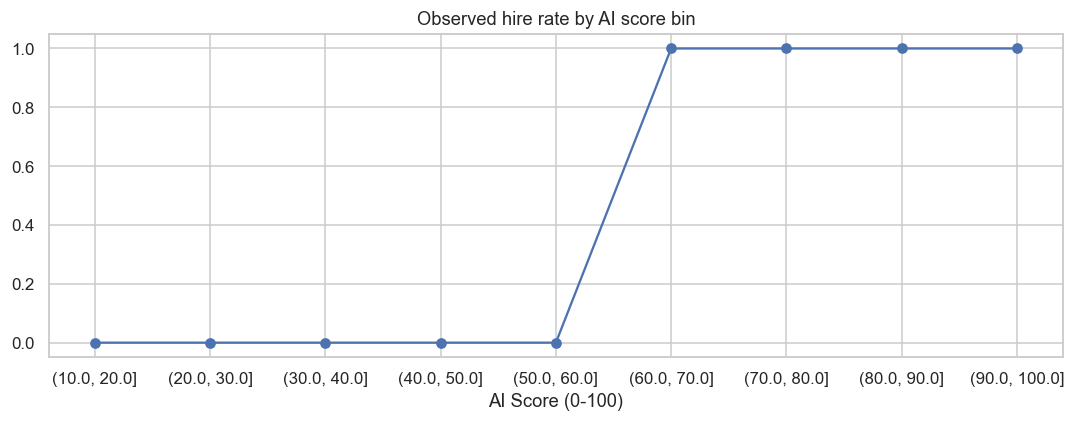

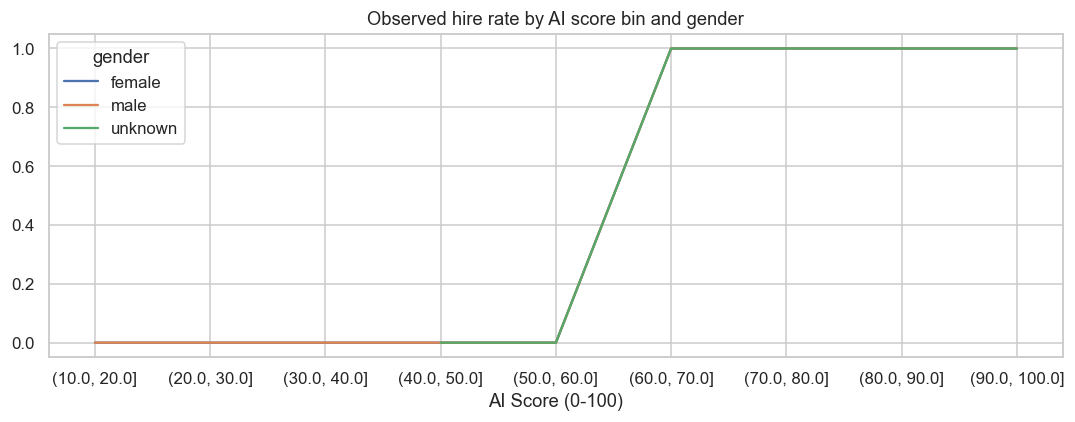

In [13]:
if AI_SCORE_COL in df.columns:
    # Check whether a higher AI score correlates with higher hire probability
    bins = pd.cut(df[AI_SCORE_COL], bins=[-0.1,10,20,30,40,50,60,70,80,90,100])
    rate = df.groupby(bins)[TARGET_COL].mean()
    rate.plot(marker='o', title='Observed hire rate by AI score bin')
    plt.tight_layout(); plt.show()

    # By gender strata
    for g in GROUP_COLS:
        sub = df.dropna(subset=[g])
        if sub[g].nunique() < 2: 
            continue
        rate_g = sub.groupby([g, bins])[TARGET_COL].mean().unstack(0)
        rate_g.plot(title=f'Observed hire rate by AI score bin and {g}')
        plt.tight_layout(); plt.show()

## 7. Model Explainability (Permutation Importance)

,feature,importance
3,AI Score (0-100),0.288754
0,Experience (Years),0.011361
1,Projects Count,0.005985
4,num_skills,0.000021
5,Job Role,0.000010
2,Salary Expectation ($),0.000000


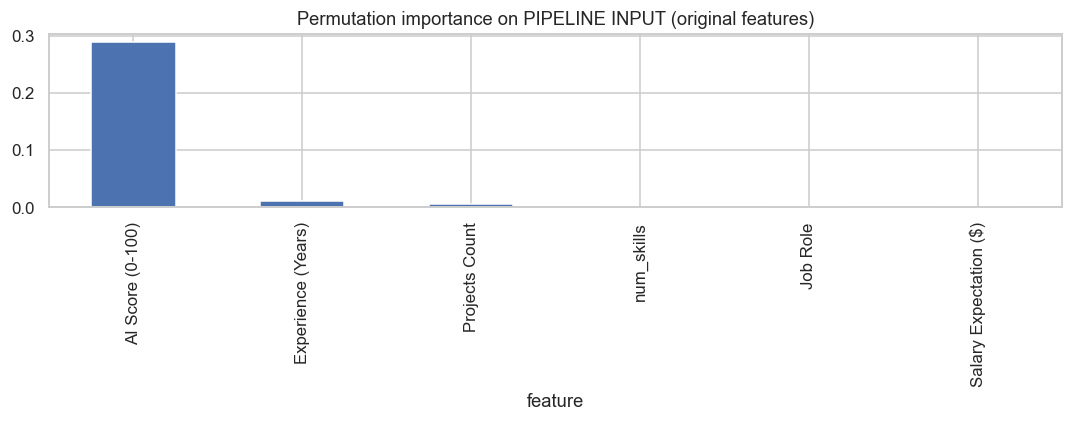

In [14]:
from sklearn.inspection import permutation_importance

r = permutation_importance(
    clf,           # the Pipeline
    X_test, y_test,
    n_repeats=10,
    random_state=RANDOM_STATE,
    scoring="roc_auc",
)

feat_names = list(X_test.columns)   # 6 original columns: 5 num + 1 categorical
imp = (
    pd.DataFrame({"feature": feat_names, "importance": r.importances_mean})
    .sort_values("importance", ascending=False)
)
display(imp.head(20))

imp.head(15).set_index("feature")["importance"].plot.bar(
    title="Permutation importance on PIPELINE INPUT (original features)"
)
plt.tight_layout(); plt.show()


## 8. Cross‑Validation for Stability

In [15]:
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
aucs = []
for fold, (tr, te) in enumerate(skf.split(X, y), 1):
    clf_cv = Pipeline(steps=[('prep', preprocess),
                            ('model', LogisticRegression(max_iter=200, class_weight='balanced', random_state=RANDOM_STATE))])
    clf_cv.fit(X.iloc[tr], y.iloc[tr])
    prob = clf_cv.predict_proba(X.iloc[te])[:,1]
    aucs.append(roc_auc_score(y.iloc[te], prob))
print("Fold AUCs:", np.round(aucs,3), "| Mean=", np.mean(aucs).round(3), "SD=", np.std(aucs).round(3))

Fold AUCs: [0.999 1.    1.    1.    1.   ] | Mean= 1.0 SD= 0.0


## 9. Reporting Helpers

In [16]:
def confusion_table(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cm, index=['True 0','True 1'], columns=['Pred 0','Pred 1'])
    return df_cm

display(confusion_table(y_test, pred_test))

,Pred 0,Pred 1
True 0,47,0
True 1,7,196


- Add `ethnicity` / `language` or other demographic proxies **only** if ethically permissible and clearly documented.
- Compare models: Logistic Regression vs. tree-based (e.g., GradientBoosting, XGBoost/LightGBM) and check **fairness diffs**.
- Tune decision threshold per group (post-processing) **and** evaluate trade-offs (equalized odds vs. overall accuracy).
- Add calibration (Platt or isotonic) and re-check group metrics.
- If `Recruiter Decision` exists, audit **disagreement analysis**: when AI score recommends hire but recruiter rejects (and vice versa).
- Conduct **counterfactual tests** (e.g., swap gender tokens when text fields exist) to estimate direct bias.
- Produce a short **Methods** and **Limitations** write-up for your Hausarbeit.


### Bootstrap-Konfidenzintervalle für Gruppenmetriken

In [17]:
# --- BOOTSTRAP CIs für TPR/FPR/Selection-Rate pro Gruppe ---
import numpy as np
import pandas as pd

def group_metrics(df_eval, group_col, y_true, y_pred):
    rows = []
    for gval, idx in df_eval.groupby(group_col, dropna=False).groups.items():
        yt = y_true.loc[idx].astype(int)
        yp = y_pred.loc[idx].astype(int)
        ppos = max((yt==1).sum(), 1)
        nneg = max((yt==0).sum(), 1)
        tpr = ((yp==1) & (yt==1)).sum() / ppos
        fpr = ((yp==1) & (yt==0)).sum() / nneg
        sel = (yp==1).mean()
        rows.append((gval if pd.notna(gval) else "NaN/Unknown", len(idx), tpr, fpr, sel))
    return pd.DataFrame(rows, columns=[group_col, "n", "TPR", "FPR", "SelectionRate"])

def bootstrap_ci_group(df_eval, group_col, y_true, y_pred, B=2000, alpha=0.05, random_state=42):
    rng = np.random.default_rng(random_state)
    groups = sorted(df_eval[group_col].dropna().unique().tolist())
    out = []
    for g in groups:
        idx = df_eval.index[df_eval[group_col]==g]
        if len(idx) < 5:  # zu klein -> skip oder grobe CI
            out.append({"group": g, "n": len(idx), "metric": "TPR", "lo": np.nan, "hi": np.nan})
            out.append({"group": g, "n": len(idx), "metric": "FPR", "lo": np.nan, "hi": np.nan})
            out.append({"group": g, "n": len(idx), "metric": "SelectionRate", "lo": np.nan, "hi": np.nan})
            continue
        yt = y_true.loc[idx].astype(int).to_numpy()
        yp = y_pred.loc[idx].astype(int).to_numpy()
        ppos = max((yt==1).sum(), 1)
        nneg = max((yt==0).sum(), 1)

        def stat(mask):
            tpr = ((yp[mask]==1) & (yt[mask]==1)).sum() / max((yt[mask]==1).sum(), 1)
            fpr = ((yp[mask]==1) & (yt[mask]==0)).sum() / max((yt[mask]==0).sum(), 1)
            sel = (yp[mask]==1).mean()
            return tpr, fpr, sel

        tprs, fprs, sels = [], [], []
        n = len(idx)
        for _ in range(B):
            b = rng.integers(0, n, size=n)
            t, f, s = stat(b)
            tprs.append(t); fprs.append(f); sels.append(s)
        for name, arr in [("TPR", tprs), ("FPR", fprs), ("SelectionRate", sels)]:
            lo, hi = np.quantile(arr, [alpha/2, 1-alpha/2])
            out.append({"group": g, "n": len(idx), "metric": name, "lo": float(lo), "hi": float(hi)})
    return pd.DataFrame(out)

# Nutzung (setzt voraus: eval_df mit 'pred', y_test, GROUP_COLS existieren)
for g in GROUP_COLS:
    print(f"\n=== {g}: Punkt-Schätzer ===")
    display(group_metrics(eval_df, g, y_test, eval_df["pred"]))
    print(f"=== {g}: 95%-Konfidenzintervalle (Bootstrap) ===")
    display(bootstrap_ci_group(eval_df, g, y_test, eval_df["pred"]))



=== gender: Punkt-Schätzer ===


,gender,n,TPR,FPR,SelectionRate
0,female,123,0.990099,0.0,0.813008
1,male,119,0.947368,0.0,0.756303
2,unknown,8,0.857143,0.0,0.750000


=== gender: 95%-Konfidenzintervalle (Bootstrap) ===


,group,n,metric,lo,hi
0,female,123,TPR,0.968742,1.000000
1,female,123,FPR,0.000000,0.000000
2,female,123,SelectionRate,0.739837,0.878049
3,male,119,TPR,0.898990,0.989250
4,male,119,FPR,0.000000,0.000000
5,male,119,SelectionRate,0.680672,0.831933
6,unknown,8,TPR,0.571429,1.000000
7,unknown,8,FPR,0.000000,0.000000
8,unknown,8,SelectionRate,0.375000,1.000000


### Threshold-Sensitivity & Fairness-Trade-offs

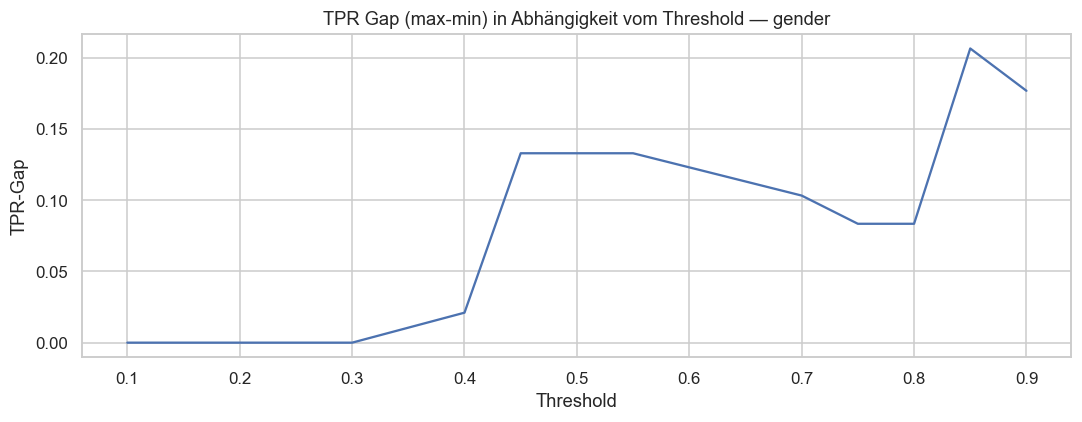

In [18]:
# --- THRESHOLD SWEEP für Post-Processing-Trade-offs ---
#  Threasholds sensitivity analysis for fairness metrics which means 
#  wie verändern sich TPR/FPR/Selection-Rate pro Gruppe bei verschiedenen Thresholds?
#  Dies ist nützlich, um zu verstehen, ob Fairness-Indikatoren stabil sind oder stark vom gewählten Schwellenwert abhängen.
#  beim Threasholding bezieht man sich auf die Spalten 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

def sweep_thresholds(df_eval, y_true, groups, score_col="proba", thresholds=np.linspace(0.1,0.9,17)):
    recs = []
    for t in thresholds:
        pred = (df_eval[score_col] >= t).astype(int)
        # Macro AUC stabil (Score-abhängig)
        auc = roc_auc_score(y_true, df_eval[score_col])
        for g in groups:
            for gval, idx in df_eval.groupby(g, dropna=False).groups.items():
                yt = y_true.loc[idx].astype(int)
                yp = pred.loc[idx].astype(int)
                ppos = max((yt==1).sum(), 1); nneg = max((yt==0).sum(), 1)
                tpr = ((yp==1)&(yt==1)).sum()/ppos
                fpr = ((yp==1)&(yt==0)).sum()/nneg
                sel = (yp==1).mean()
                recs.append({"thr": t, "group": g, "gval": "NaN/Unknown" if pd.isna(gval) else gval,
                             "TPR": tpr, "FPR": fpr, "SelectionRate": sel, "AUC": auc})
    return pd.DataFrame(recs)

thr_df = sweep_thresholds(eval_df, y_test, GROUP_COLS)

# Beispielplot: TPR-Differenz (max-min) über Thresholds
for g in GROUP_COLS:
    tmp = thr_df[thr_df["group"]==g].pivot(index="thr", columns="gval", values="TPR")
    gap = tmp.max(axis=1) - tmp.min(axis=1)
    ax = gap.plot(title=f"TPR Gap (max-min) in Abhängigkeit vom Threshold — {g}")
    plt.xlabel("Threshold"); plt.ylabel("TPR-Gap"); plt.tight_layout(); plt.show()


### Model without AI score

In [19]:
# --- Ablationsmodell ohne AI-Score ---
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, accuracy_score, precision_recall_fscore_support, brier_score_loss

NUM_NO_SCORE = [c for c in NUM_COLS if c != AI_SCORE_COL]
X2 = df[NUM_NO_SCORE + CAT_COLS].copy()
y2 = df[TARGET_COL].astype(int)

X2_tr, X2_te, y2_tr, y2_te = train_test_split(X2, y2, test_size=TEST_SIZE, stratify=y2, random_state=RANDOM_STATE)

prep2 = ColumnTransformer([
    ("num", Pipeline([("sc", StandardScaler())]), NUM_NO_SCORE),
    ("cat", Pipeline([("ohe", OneHotEncoder(handle_unknown="ignore"))]), CAT_COLS),
])

clf2 = Pipeline([("prep", prep2), ("model", LogisticRegression(max_iter=300, class_weight="balanced", random_state=RANDOM_STATE))])
clf2.fit(X2_tr, y2_tr)
pro2 = clf2.predict_proba(X2_te)[:,1]
pr2 = (pro2 >= 0.5).astype(int)

def summarize_perf(y_true, proba, pred, label):
    auc = roc_auc_score(y_true, proba)
    acc = accuracy_score(y_true, pred)
    p,r,f1,_ = precision_recall_fscore_support(y_true, pred, average='binary', zero_division=0)
    bri = brier_score_loss(y_true, proba)
    print(f"{label}: AUC={auc:.3f} Acc={acc:.3f} F1={f1:.3f} P={p:.3f} R={r:.3f} Brier={bri:.3f}")

print("\n=== Vergleich mit Basis (mit AI-Score) ===")
summarize_perf(y_test, eval_df["proba"], eval_df["pred"], "MIT AI-Score")
summarize_perf(y2_te, pro2, pr2, "OHNE AI-Score")

# Fairness auch hier prüfen
eval2 = X2_te.copy()
for g in GROUP_COLS:
    if g in df.columns:
        eval2[g] = df.loc[X2_te.index, g]
eval2["proba"] = pro2; eval2["pred"] = pr2

display(eval2.groupby(GROUP_COLS[0])["pred"].mean().rename("SelectionRate (ohne Score)"))



=== Vergleich mit Basis (mit AI-Score) ===
MIT AI-Score: AUC=1.000 Acc=0.972 F1=0.982 P=1.000 R=0.966 Brier=0.016
OHNE AI-Score: AUC=0.999 Acc=0.956 F1=0.972 P=1.000 R=0.946 Brier=0.032


gender
female     0.780488
male       0.756303
unknown    0.750000
Name: SelectionRate (ohne Score), dtype: float64

### Modellvergleich (LogReg vs. GradientBoosting)

In [20]:
# --- Model Compare: Logistic vs GradientBoosting ---
from sklearn.ensemble import GradientBoostingClassifier

def fit_eval_model(estimator, X_tr, y_tr, X_te, y_te, label):
    pipe = Pipeline([("prep", preprocess), ("model", estimator)])
    pipe.fit(X_tr, y_tr)
    pro = pipe.predict_proba(X_te)[:,1]
    prd = (pro >= 0.5).astype(int)
    summarize_perf(y_te, pro, prd, label)
    return pipe, pro, prd

gb = GradientBoostingClassifier(random_state=RANDOM_STATE)
clf_gb, pro_gb, prd_gb = fit_eval_model(gb, X_train, y_train, X_test, y_test, "GradientBoosting")

# Gruppendiffs vergleichen
eval_gb = X_test.copy()
for g in GROUP_COLS:
    eval_gb[g] = df.loc[X_test.index, g]
eval_gb["proba"] = pro_gb; eval_gb["pred"] = prd_gb

def fairness_gap(eval_df, group, y_true, y_pred, metric="TPR"):
    rows = []
    for gval, idx in eval_df.groupby(group, dropna=False).groups.items():
        yt = y_true.loc[idx].astype(int); yp = y_pred.loc[idx].astype(int)
        if metric=="TPR":
            val = ((yp==1)&(yt==1)).sum()/max((yt==1).sum(),1)
        elif metric=="FPR":
            val = ((yp==1)&(yt==0)).sum()/max((yt==0).sum(),1)
        elif metric=="Selection":
            val = (yp==1).mean()
        rows.append(val)
    return np.nanmax(rows) - np.nanmin(rows)

for metr in ["TPR","FPR","Selection"]:
    base_gap = fairness_gap(eval_df, GROUP_COLS[0], y_test, eval_df["pred"], metr)
    gb_gap   = fairness_gap(eval_gb, GROUP_COLS[0], y_test, eval_gb["pred"], metr)
    print(f"{metr} gap (max-min): Base={base_gap:.3f} | GB={gb_gap:.3f}")


GradientBoosting: AUC=1.000 Acc=1.000 F1=1.000 P=1.000 R=1.000 Brier=0.000
TPR gap (max-min): Base=0.133 | GB=0.000
FPR gap (max-min): Base=0.000 | GB=0.000
Selection gap (max-min): Base=0.063 | GB=0.077


### Kalibrierung (Isotonic & Platt) + Fairness neu prüfen

In [21]:
# --- Calibration with CalibratedClassifierCV ---
from sklearn.calibration import CalibratedClassifierCV

base = Pipeline([("prep", preprocess), ("model", LogisticRegression(max_iter=300, class_weight="balanced", random_state=RANDOM_STATE))])
base.fit(X_train, y_train)

cal_iso = CalibratedClassifierCV(base, cv=5, method="isotonic")
cal_iso.fit(X_train, y_train)

cal_sig = CalibratedClassifierCV(base, cv=5, method="sigmoid")
cal_sig.fit(X_train, y_train)

def eval_calibrated(model, label):
    pro = model.predict_proba(X_test)[:,1]
    prd = (pro >= 0.5).astype(int)
    summarize_perf(y_test, pro, prd, label)
    # Gruppen
    tmp = X_test.copy()
    for g in GROUP_COLS:
        tmp[g] = df.loc[X_test.index, g]
    tmp["proba"] = pro; tmp["pred"] = prd
    display(tmp.groupby(GROUP_COLS[0])["pred"].mean().rename(f"SelectionRate {label}"))

print("\n=== Calibration ===")
eval_calibrated(cal_iso, "Isotonic")
eval_calibrated(cal_sig, "Platt/Sigmoid")



=== Calibration ===
Isotonic: AUC=1.000 Acc=1.000 F1=1.000 P=1.000 R=1.000 Brier=0.000


gender
female     0.821138
male       0.798319
unknown    0.875000
Name: SelectionRate Isotonic, dtype: float64

Platt/Sigmoid: AUC=1.000 Acc=1.000 F1=1.000 P=1.000 R=1.000 Brier=0.016


gender
female     0.821138
male       0.798319
unknown    0.875000
Name: SelectionRate Platt/Sigmoid, dtype: float64

In [22]:
# --- Disagreement Analysis ---
assert DECISION_COL in df.columns, f"{DECISION_COL} fehlt"

te_idx = X_test.index
test_df = df.loc[te_idx, [DECISION_COL, TARGET_COL, AI_SCORE_COL] + GROUP_COLS].copy()
test_df["model_proba"] = eval_df["proba"]
test_df["model_pred"]  = eval_df["pred"]

# Score-basierte "Empfehlung" (Cutoff 60 aus deiner Kurve)
test_df["score_recommend"] = (test_df[AI_SCORE_COL] >= 60).astype(int)

# Konflikte
conflicts = pd.DataFrame({
    "AIhigh_HumanReject": ((test_df["score_recommend"]==1) & (test_df[DECISION_COL].str.lower()=="reject")).sum(),
    "AIlow_HumanHire":    ((test_df["score_recommend"]==0) & (test_df[DECISION_COL].str.lower()=="hire")).sum(),
    "Model_Human_Disagree": (test_df["model_pred"] != (test_df[DECISION_COL].str.lower()=="hire").astype(int)).sum()
}, index=["count"]).T
display(conflicts)

# Nach Gruppe
dis_by_group = test_df.assign(human_hire=(test_df[DECISION_COL].str.lower()=="hire").astype(int))
dis_by_group = dis_by_group.groupby(GROUP_COLS[0]).apply(
    lambda d: pd.Series({
        "AIhigh_HumanReject": ((d["score_recommend"]==1) & (d["human_hire"]==0)).mean(),
        "AIlow_HumanHire":    ((d["score_recommend"]==0) & (d["human_hire"]==1)).mean(),
        "Model_Human_Disagree": (d["model_pred"] != d["human_hire"]).mean()
    })
)
display(dis_by_group)


,count
AIhigh_HumanReject,11
AIlow_HumanHire,0
Model_Human_Disagree,7


,AIhigh_HumanReject,AIlow_HumanHire,Model_Human_Disagree
gender,,,
female,0.032520,0.0,0.008130
male,0.058824,0.0,0.042017
unknown,0.000000,0.0,0.125000


,sigma,AUC,Acc
0,2,1.000000,0.968
1,5,0.997380,0.976
2,10,0.998742,0.968
3,15,0.999266,0.948


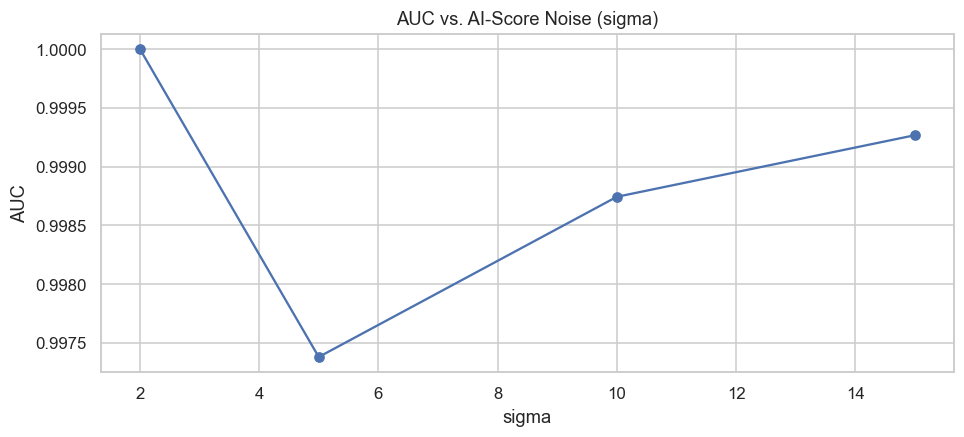

In [23]:
# --- Noise stress test on AI Score ---
import numpy as np

def noise_experiment(df, noise_sigmas=(2,5,10,15)):
    rows = []
    for s in noise_sigmas:
        df_noisy = df.copy()
        df_noisy[AI_SCORE_COL] = (df_noisy[AI_SCORE_COL] + np.random.normal(0, s, size=len(df_noisy))).clip(0,100)
        Xn = df_noisy[NUM_COLS + CAT_COLS]
        yn = df_noisy[TARGET_COL].astype(int)
        Xn_tr, Xn_te, yn_tr, yn_te = train_test_split(Xn, yn, test_size=TEST_SIZE, stratify=yn, random_state=RANDOM_STATE)
        model = Pipeline([("prep", preprocess), ("model", LogisticRegression(max_iter=300, class_weight="balanced", random_state=RANDOM_STATE))])
        model.fit(Xn_tr, yn_tr)
        pro = model.predict_proba(Xn_te)[:,1]
        prd = (pro >= 0.5).astype(int)
        auc = roc_auc_score(yn_te, pro)
        rows.append({"sigma": s, "AUC": auc, "Acc": accuracy_score(yn_te, prd)})
    return pd.DataFrame(rows)

noise_res = noise_experiment(df)
display(noise_res)
ax = noise_res.set_index("sigma")["AUC"].plot(marker="o", title="AUC vs. AI-Score Noise (sigma)")
plt.ylabel("AUC"); plt.show()


In [24]:
from sklearn.metrics import confusion_matrix
import pandas as pd

def confusion_table(y_true, y_pred, labels=None):
    """
    Gibt eine Pandas DataFrame Konfusionsmatrix zurück mit Zeilen: "True 0 / True 1"
    und Spalten: "Pred 0 / Pred 1".
    Optional labels: z. B. [0,1] oder ["no", "yes"], etc.
    """
    # Standardmäßig Labels 0 und 1, wenn nicht angegeben
    if labels is None:
        labels = sorted(list({*y_true.unique(), *y_pred.unique()}))
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    # cm ist ein numpy array [[TN, FP], [FN, TP]] wenn labels=[0,1]
    # Konvertiere in DataFrame:
    df_cm = pd.DataFrame(
        cm,
        index=[f"True_{lab}" for lab in labels],
        columns=[f"Pred_{lab}" for lab in labels]
    )
    return df_cm

# Beispiel: so benutzt du es vorher, und so exportierst du es
ct = confusion_table(y_test, eval_df["pred"], labels=[0,1])
print(ct)
ct.to_csv("exports/confusion_matrix.csv")



        Pred_0  Pred_1
True_0      47       0
True_1       7     196


Grundlegende Modellmetriken: {'accuracy': 1.0, 'auc': 1.0, 'f1': 1.0}
Leistungskennzahlen pro Gruppe:
     group    n  pos_rate_true  selection_rate  TPR  FPR  TNR  FNR  Precision  \
0   female  123       0.821138        0.821138  1.0  0.0  1.0  0.0        1.0   
1     male  119       0.798319        0.798319  1.0  0.0  1.0  0.0        1.0   
2  unknown    8       0.875000        0.875000  1.0  0.0  1.0  0.0        1.0   

   NPV  AUC     Brier  
0  1.0  1.0  0.000152  
1  1.0  1.0  0.000300  
2  1.0  1.0  0.000391  
Unterschiede in den 'Equalized Odds': {'TPR_gap': 0.0, 'FPR_gap': 0.0}
Unterschiede in der 'Demographischen Parität': 0.07668067226890751
Kalibrierungsübersicht pro Gruppe:
     group       ECE     Brier    n
0   female  0.006190  0.000152  123
1     male  0.008648  0.000300  119
2  unknown  0.012330  0.000391    8
Ergebnisse der Schwellenwertanalyse (Threshold-Sweep):
   threshold  accuracy  macro_f1  TPR_gap  FPR_gap  Selection_gap
0       0.10       1.0       1.0      0

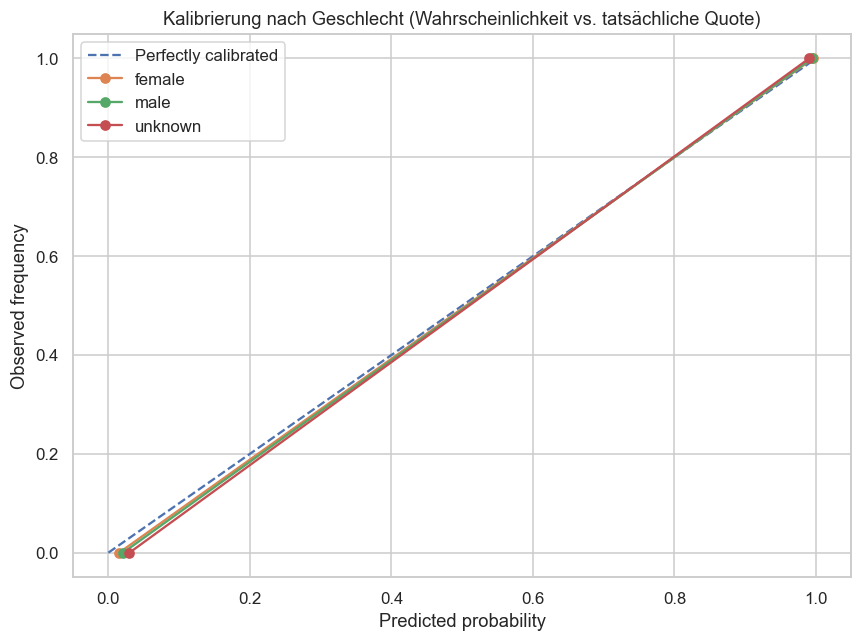

In [25]:
import numpy as np
import pandas as pd
from fairness_quickstart import build_and_predict
from fairness_metrics import (
    compute_group_rates, equalized_odds_gaps, demographic_parity_gap,
    calibration_by_group, threshold_sweep, plot_calibration_by_group
)

# df muss bereits existieren
# Beispiel: df enthält Spalten wie ["gender", "ai_score", "hire_decision"]
res = build_and_predict(df, group_col="gender", threshold=0.5)

# Ergebnisse extrahieren
y_true, y_prob, y_pred, group = res["y_true"], res["y_prob"], res["y_pred"], res["group"]

print("Grundlegende Modellmetriken:", res["metrics"])

# 1) Gruppenweise Auswertung
gr = compute_group_rates(y_true, y_pred, y_prob, group)
print("Leistungskennzahlen pro Gruppe:")
print(gr)

# 2) Fairness-Metriken: Equalized Odds & Demographic Parity
eo = equalized_odds_gaps(gr)
dp = demographic_parity_gap(gr)

print("Unterschiede in den 'Equalized Odds':", eo)
print("Unterschiede in der 'Demographischen Parität':", dp)

# 3) Kalibrierung pro Gruppe
curves, calib_summary = calibration_by_group(y_true, y_prob, group, n_bins=10)
print("Kalibrierungsübersicht pro Gruppe:")
print(calib_summary)

fig = plot_calibration_by_group(
    curves,
    title="Kalibrierung nach Geschlecht (Wahrscheinlichkeit vs. tatsächliche Quote)"
)
fig.show()

# 4) Threshold-Analyse (Schwellenwert-Sweep)
sweep = threshold_sweep(y_true, y_prob, group, thresholds=np.linspace(0.1, 0.9, 17))
print("Ergebnisse der Schwellenwertanalyse (Threshold-Sweep):")
print(sweep.head())


📊 Grundlegende Modellmetriken:
{'accuracy': 1.0, 'auc': 1.0, 'f1': 1.0}

📈 Leistungskennzahlen pro Gruppe:
     group    n  pos_rate_true  selection_rate  TPR  FPR  TNR  FNR  Precision  \
0   female  123       0.821138        0.821138  1.0  0.0  1.0  0.0        1.0   
1     male  119       0.798319        0.798319  1.0  0.0  1.0  0.0        1.0   
2  unknown    8       0.875000        0.875000  1.0  0.0  1.0  0.0        1.0   

   NPV  AUC     Brier  
0  1.0  1.0  0.000152  
1  1.0  1.0  0.000300  
2  1.0  1.0  0.000391  

⚖️ Unterschiede in den 'Equalized Odds': {'TPR_gap': 0.0, 'FPR_gap': 0.0}
⚖️ Unterschiede in der 'Demographischen Parität': 0.07668067226890751

📏 Kalibrierungsübersicht pro Gruppe:
     group       ECE     Brier    n
0   female  0.006190  0.000152  123
1     male  0.008648  0.000300  119
2  unknown  0.012330  0.000391    8


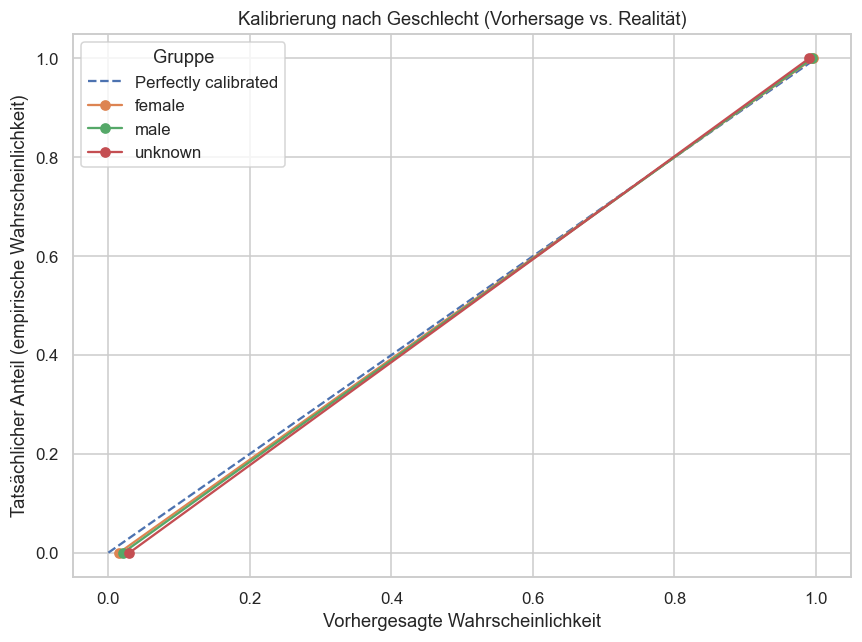


🧭 Ergebnisse der Schwellenwertanalyse (Threshold-Sweep):
   threshold  accuracy  macro_f1  TPR_gap  FPR_gap  Selection_gap
0       0.10       1.0       1.0      0.0      0.0       0.076681
1       0.15       1.0       1.0      0.0      0.0       0.076681
2       0.20       1.0       1.0      0.0      0.0       0.076681
3       0.25       1.0       1.0      0.0      0.0       0.076681
4       0.30       1.0       1.0      0.0      0.0       0.076681


In [27]:
import numpy as np
import pandas as pd
from fairness_quickstart import build_and_predict
from fairness_metrics import (
    compute_group_rates, equalized_odds_gaps, demographic_parity_gap,
    calibration_by_group, threshold_sweep, plot_calibration_by_group
)
import matplotlib.pyplot as plt

# ==============================
# 1) Datengrundlage & Modell
# ==============================
# df muss bereits existieren (z. B. mit Spalten ["gender", "ai_score", "hire_decision"])
res = build_and_predict(df, group_col="gender", threshold=0.5)

y_true, y_prob, y_pred, group = res["y_true"], res["y_prob"], res["y_pred"], res["group"]
print("📊 Grundlegende Modellmetriken:")
print(res["metrics"])

# ==============================
# 2) Gruppenweise Auswertung
# ==============================
gr = compute_group_rates(y_true, y_pred, y_prob, group)
print("\n📈 Leistungskennzahlen pro Gruppe:")
print(gr)

# ==============================
# 3) Fairness-Metriken
# ==============================
eo = equalized_odds_gaps(gr)
dp = demographic_parity_gap(gr)
print("\n⚖️ Unterschiede in den 'Equalized Odds':", eo)
print("⚖️ Unterschiede in der 'Demographischen Parität':", dp)

# ==============================
# 4) Kalibrierung pro Gruppe
# ==============================
curves, calib_summary = calibration_by_group(y_true, y_prob, group, n_bins=10)
print("\n📏 Kalibrierungsübersicht pro Gruppe:")
print(calib_summary)

# Plot mit deutschen Achsenbeschriftungen
fig = plot_calibration_by_group(
    curves,
    title="Kalibrierung nach Geschlecht"
)
plt.xlabel("Vorhergesagte Wahrscheinlichkeit")
plt.ylabel("Tatsächlicher Anteil (empirische Wahrscheinlichkeit)")
plt.title("Kalibrierung nach Geschlecht (Vorhersage vs. Realität)")
plt.legend(title="Gruppe", loc="best")
plt.grid(True)
plt.show()

# ==============================
# 5) Threshold-Analyse
# ==============================
sweep = threshold_sweep(y_true, y_prob, group, thresholds=np.linspace(0.1, 0.9, 17))
print("\n🧭 Ergebnisse der Schwellenwertanalyse (Threshold-Sweep):")
print(sweep.head())
